**Using least squares regression to estimate what the cut-off ratio will be in the future**

- First we do this using track evolution - cutoff ratios
- Then we do it based on what the historical cutoff points were

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy import interpolate

In [2]:
## Getting a list of all event files in the right format for the read data function ##

files = os.listdir('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times')

all_events = []

for file in files:
    all_events.append(file[0:16])
    
all_events.remove('.DS_Store') 

In [3]:
## Remove 2020 events ##
drop = []

for event in all_events:
    if event[-4:] == '2020':
        drop.append(event)
        
events = [x for x in all_events if x not in drop]    

**Year on Year cut-off improvement**

In [4]:
## Finds the intersection between three lists - tells us which tracks are in all three years ##

def intersect(a, b, c):
    
    intersection = list(set(a) & set(b) & set(c))
    
    return intersection

In [5]:
## Remove tracks that are not in all three years from our events list ##

event_2017 = []
event_2018 = []
event_2019 = []

# Append the track ID to a list for each year
for event in events:
    
    if event[-4:] == '2017':
        event_2017.append(event[5:8])
    else:
        pass
    
    if event[-4:] == '2018':
        event_2018.append(event[5:8])
    else:
        pass
    
    if event[-4:] == '2019':
        event_2019.append(event[5:8])
    else:
        pass

consecutive_tracks = intersect(event_2017, event_2018, event_2019)

consecutive_events = []

for event in events:
    
    if event[5:8] in consecutive_tracks:
        consecutive_events.append(event)

#assert len(consecutive_events) == len(consecutive_tracks) * 3

In [6]:
alls = set(event_2017).union(set(event_2018), set(event_2019))
print(len(alls))

22


**Load and Clean Data**

In [7]:
## Function reads data into a Pandas DataFrame from a CSV file ##

def read_data(filename):
    
    df = pd.read_csv('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times/%s.csv' % (filename))
    
    # select required features
    d = df[['Season', 'Circuit', 'Session', 'Driver Short Name', 'Team', 'Outing Number','Lap number',
                   'Sector 1', 'Sector 2', 'Sector 3', 'Full Lap (no fuel adjustment)']].copy()
    
    ''' some sectors have missing values (probably where car has been taken off, 
    convert the white space to NaN objects and drop them'''
    
    d.replace(' ', np.nan, inplace = True) 
                                              
    data = d.dropna()
    
    return data

**Produce object that contains all information based on best actual lap times per driver per track per season per session**

In [8]:
## Function finds which drivers made it into each sub-session ##

def find_drivers(data, session):
    
    session_data = data[data.loc[:,'Session'] == session]
    drivers = list(np.unique(session_data['Driver Short Name']))
    
    return drivers

In [9]:
## Function finds the fastest actual lap for each driver - run when looking for actual laptimes ## 

def fastest_actual_lap(data, driver, session):
    
    driver_sesh = data.loc[(data.loc[:, 'Driver Short Name'] == driver) & (data.Session == session), :]
    
    fastest = np.min(driver_sesh['Full Lap (no fuel adjustment)'])
    
    #print(f'The fastest theoretical lap for {team} in {session} is {fastest} seconds')
    
    season = data.loc[1, 'Season'] # finds the season of the fastest theoretical lap
    circuit = data.loc[1, 'Circuit'] # finds the circuit of the fastest theoretical lap
    
    team = driver_sesh.loc[driver_sesh.loc[:, 'Full Lap (no fuel adjustment)'] == fastest].iloc[0, 4] # finds the team of the fastest theoretical lap
    
    return season, circuit, team, driver, session, fastest

In [10]:
## Function puts the fastest Actual lap per team into a dictionary where the qualifying session is the key ##

def create_qualifier_dict(data, sessions):
    
    qualifiers = {} # {'Q1' : df, 'Q2': df, 'Q3': df}
    
    for s in sessions:

        drivers = find_drivers(data, s)

        df = pd.DataFrame(columns = ['Season', 'Circuit', 'Team', 'Driver', 'Session', 'Fastest Actual Lap Time'])

        for d in drivers:

            season, circuit, team, driver, session, fastest = fastest_actual_lap(data, driver = d, session = s) 
            
            to_append = [season, circuit, team, driver, session, fastest] # values to append to empty dataframe
            a_series = pd.Series(to_append, index = df.columns) # convert into a series first
            df = df.append(a_series, ignore_index = True) 

        df = df.sort_values(by = ['Fastest Actual Lap Time'])

        qualifiers[s] = df # adds each set of results into a dictionary that has {qualifying round: data frame of fastest laps}
       
        
    return qualifiers, circuit

In [11]:
## Runs through all events available and works out actual laps for each qualifying session specified ##

sessions = ['Q1', 'Q2']

q = []
c = []

for event in consecutive_events:
    
    data = read_data(event)
    #data, Q1_data, Q2_data = clean_data(d) do not clean here otherwise we lose actual laps that contributed to qualifying scores
    
    qualifiers, circuit = create_qualifier_dict(data, sessions)
    
    q.append(qualifiers)
    c.append(circuit)

assert len(q) == len(c)

circuit_fastest_laps = defaultdict(list) # returns a dictionary where the keys are circuits and the values are qualifying dictionaries for each year

for i, j in zip(c, q):
    circuit_fastest_laps[i].append(j)

print(circuit_fastest_laps.keys())

dict_keys(['Sochi', 'Monza', 'Suzuka', 'A1-Ring', 'Melbourne', 'Mexico City', 'Bahrain', 'Montreal', 'Spa', 'Baku', 'Monaco', 'Austin', 'Interlagos', 'Silverstone', 'Shanghai', 'Abu Dhabi', 'Barcelona', 'Singapore', 'Budapest'])


In [12]:
## Returns dictionary containing the laps for Q1 and Q2 when track and year specified ##

def return_dict(year, track, res):
    
    if res[track][0]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][0]['Q1'], 'Q2': res[track][0]['Q2']}
    
    else:
        pass
    
    if res[track][1]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][1]['Q1'], 'Q2': res[track][1]['Q2']}
    
    else:
        pass
    
    if res[track][2]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][2]['Q1'], 'Q2': res[track][2]['Q2']}
    
    else:
        print('Enter valid arguments: year is not a string, track is a string')
     

In [13]:
## Finds cut-off points ##

def find_cutoff(input_data):

    Q1 = input_data['Q1']
    Q2 = input_data['Q2']
    
    Q1_cut = Q1.iloc[:, -1].nsmallest(16).iloc[-1] # 16th place is the score to beat, base it on below the 8th
    Q2_cut = Q2.iloc[:, -1].nsmallest(11).iloc[-1] # 11th place is the score to beat, base it on below the 5th
  
    #print(f'Q1 cut-off is {round(Q1_cut, 3)} seconds')
    #print(f'Q2 cut-off is {round(Q2_cut, 3)} seconds')
    
    return Q1_cut, Q2_cut

In [14]:
## Actual cut-off - note that slow laps have not been removed as not to skew the actual value of cut-off ##

seasons = [2017, 2018, 2019]

Q1_actual = []
Q2_actual = []

for season in seasons:
    
   # print(f'Season {season}:')
    event = return_dict(season, 'Baku', circuit_fastest_laps)
    Q1_cut, Q2_cut = find_cutoff(event)
    
    #display(event['Q1'])
    #display(event['Q2'])
    
    Q1_actual.append(Q1_cut)
    Q2_actual.append(Q2_cut)

**Extrapolation on Q1/Q2 cut-off ratios**

In [15]:
## Find the Q1 and Q2 cut-off points and the speed ratios for all years for all tracks - return info in DF ##


Q1_cutoff_ratios = pd.DataFrame(columns = ['Circuit', 'Cut-off 17-18', 'Cut-off 18-19', 'Predicted Cut-off 19_20', 'Ratio Cut-off 2020 (pred)'])
Q2_cutoff_ratios = pd.DataFrame(columns = ['Circuit', 'Cut-off 17-18', 'Cut-off 18-19', 'Predicted Cut-off 19_20', 'Ratio Cut-off 2020 (pred)'])


for track in circuit_fastest_laps.keys():
    
    event_2017 = return_dict(2017, track, circuit_fastest_laps)
    Q1_cut_2017, Q2_cut_2017 = find_cutoff(event_2017)
    
    event_2018 = return_dict(2018, track, circuit_fastest_laps)
    Q1_cut_2018, Q2_cut_2018 = find_cutoff(event_2018)
    
    event_2019 = return_dict(2019, track, circuit_fastest_laps)
    Q1_cut_2019, Q2_cut_2019 = find_cutoff(event_2019)
    
    Q1_ratio_17_18 = round(Q1_cut_2018/ Q1_cut_2017, 3)
    Q1_ratio_18_19 = round(Q1_cut_2019/ Q1_cut_2018, 3)
    #Q1_ratio_17_19 = round(Q1_cut_2019/ Q1_cut_2017, 3)
    
    # predict 19_20 ratio
    x1 = np.array([2018, 2019])
    y1 = np.array([Q1_cut_2018/ Q1_cut_2017, Q1_cut_2019/ Q1_cut_2018])
    
    extrapolate_1 = interpolate.interp1d(x1, y1, fill_value = 'extrapolate')
    Q1_ratio_19_20 = np.round(extrapolate_1(2020), 3)
    
    # estimate what the 2020 cut-off would be based on the pred ratio
    Q1_2020_pred = round(Q1_cut_2019 * Q1_ratio_19_20, 3) 
    
    
    #print(f'Q1 track - {track}, 17:18 - {Q1_ratio_17_18}, 18:19 - {Q1_ratio_18_19}, 17:19 - {Q1_ratio_17_19}')  
    
    to_append = [track, Q1_ratio_17_18, Q1_ratio_18_19, Q1_ratio_19_20, Q1_2020_pred] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q1_cutoff_ratios.columns) # convert into a series first
    Q1_cutoff_ratios = Q1_cutoff_ratios.append(series, ignore_index = True) 
    
    
    Q2_ratio_17_18 = round(Q2_cut_2018/ Q2_cut_2017, 3)
    Q2_ratio_18_19 = round(Q2_cut_2019/ Q2_cut_2018, 3)
    #Q2_ratio_17_19 = round(Q2_cut_2019/ Q2_cut_2017, 3)
    
    # predict 19_20 ratio
    x2 = np.array([2018, 2019])
    y2 = np.array([Q2_cut_2018/ Q2_cut_2017, Q2_cut_2019/ Q2_cut_2018])
    
    extrapolate_2 = interpolate.interp1d(x2, y2, fill_value = 'extrapolate')
    Q2_ratio_19_20 = np.round(extrapolate_2(2020), 3)
    
    # estimate what the 2020 cut-off would be based on the pred ratio
    Q2_2020_pred = round(Q2_cut_2019 * Q2_ratio_19_20, 3) 
    
    to_append = [track, Q2_ratio_17_18, Q2_ratio_18_19, Q2_ratio_19_20, Q2_2020_pred] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q2_cutoff_ratios.columns) # convert into a series first
    Q2_cutoff_ratios = Q2_cutoff_ratios.append(series, ignore_index = True) 
        
    #print(f'Q2 track - {track}, 17:18 - {Q2_ratio_17_18}, 18:19 - {Q2_ratio_18_19}, 17:19 - {Q2_ratio_17_19}') 

In [16]:
 Q1_cutoff_ratios

,Circuit,Cut-off 17-18,Cut-off 18-19,Predicted Cut-off 19_20,Ratio Cut-off 2020 (pred)
0,Sochi,0.985,0.998,1.011,95.883
1,Monza,0.815,0.987,1.158,93.548
2,Suzuka,0.995,0.994,0.993,89.193
3,A1-Ring,0.984,0.993,1.001,64.854
4,Melbourne,0.978,0.982,0.986,81.855
5,Mexico City,0.971,1.015,1.059,82.671
6,Bahrain,0.983,0.994,1.006,90.566
7,Montreal,0.985,0.988,0.992,71.619
8,Spa,0.985,1.019,1.052,111.970
9,Baku,1.001,0.982,0.963,98.833


In [17]:
 Q2_cutoff_ratios

,Circuit,Cut-off 17-18,Cut-off 18-19,Predicted Cut-off 19_20,Ratio Cut-off 2020 (pred)
0,Sochi,0.980,1.000,1.019,95.735
1,Monza,0.837,0.986,1.135,91.387
2,Suzuka,1.001,0.993,0.985,87.915
3,A1-Ring,0.989,0.995,1.001,64.554
4,Melbourne,0.984,0.986,0.989,81.654
5,Mexico City,0.984,0.998,1.012,77.607
6,Bahrain,0.991,0.993,0.995,89.041
7,Montreal,0.985,0.989,0.993,71.297
8,Spa,0.988,1.009,1.030,107.941
9,Baku,1.004,0.989,0.973,99.633


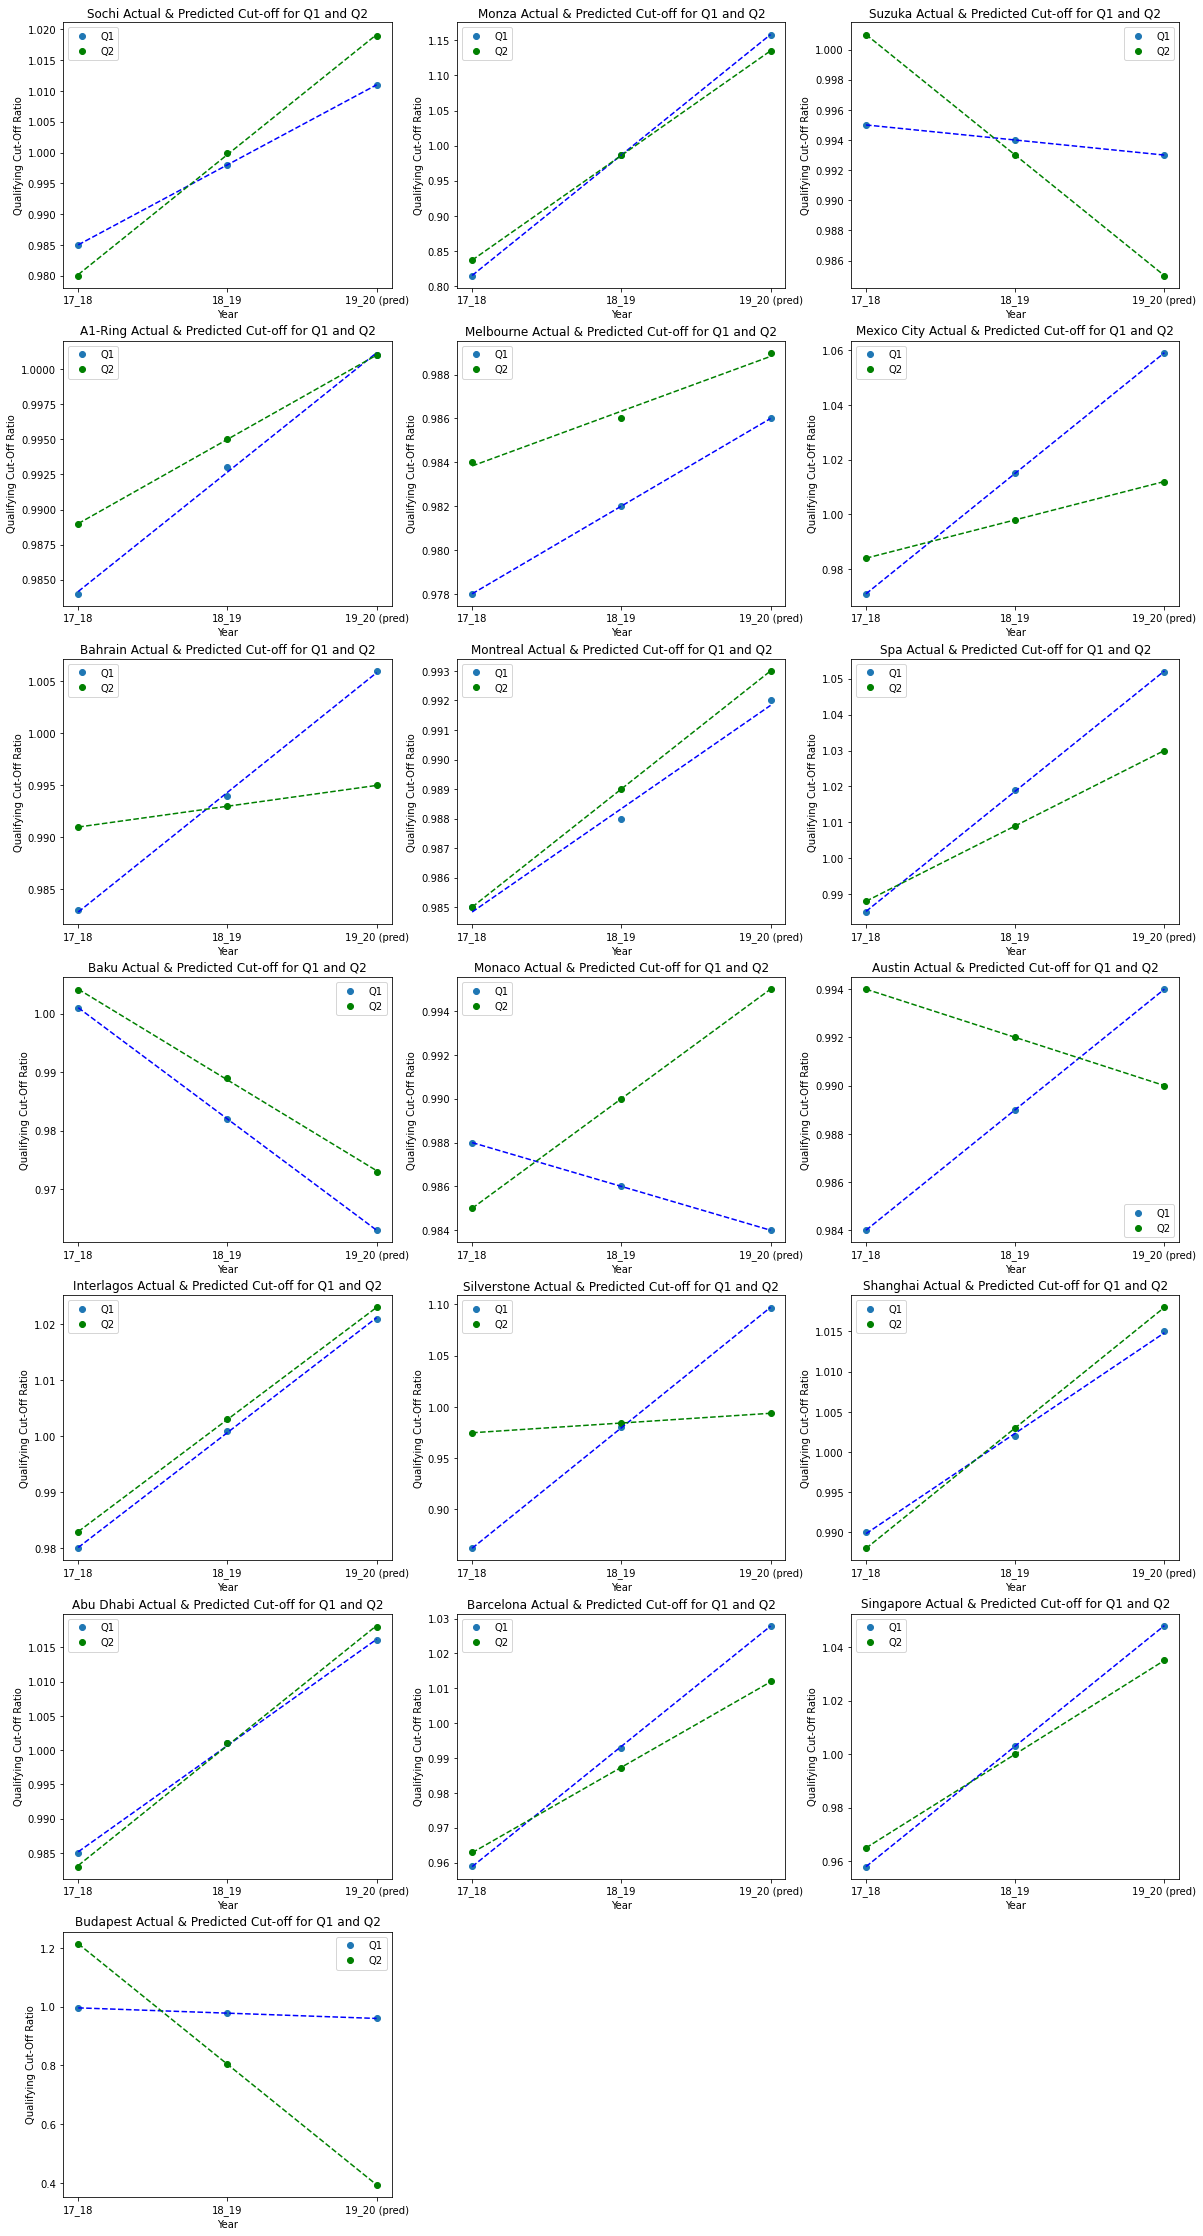

In [18]:
Q1 =  Q1_cutoff_ratios
Q2 =  Q2_cutoff_ratios

x = np.array([2018, 2019, 2020])

fig1 = plt.figure(figsize = (20, 40))

for i in range(1, 20):
    
    y1 = np.array([Q1.loc[i - 1][1], Q1.loc[i - 1][2], Q1.loc[i - 1][3]])
    y2 = np.array([Q2.loc[i - 1][1], Q2.loc[i - 1][2], Q2.loc[i - 1][3]])


    m1, c1 = np.polyfit(x, y1, 1) # least squares regression
    m2, c2 = np.polyfit(x, y2, 1)

    Y1 = m1 * x + c1
    Y2 = m2 * x + c2
    
    sub = fig1.add_subplot(7, 3, i)

    sub.plot(x, y1, 'o')
    sub.plot(x, y2, 'o', color = 'g')

    sub.plot(x, Y1, linestyle = '--', color = 'b')
    sub.plot(x, Y2, linestyle = '--', color = 'g')

    labels = ['17_18', '18_19', '19_20 (pred)']
    
    sub.set_ylabel('Qualifying Cut-Off Ratio')
    sub.set_title(f'{Q1.loc[i - 1][0]} Actual & Predicted Cut-off for Q1 and Q2')
    sub.set_xlabel('Year')
    sub.set_xticks([2018, 2019, 2020])
    sub.set_xticklabels(labels)
    sub.legend(('Q1', 'Q2'))
    

**Extrapolation on cut-off values**

In [21]:
## Find the Q1 and Q2 cut-off points and the speed ratios for all years for all tracks - return info in DF ##


Q1_cutoff = pd.DataFrame(columns = ['Circuit', 'Cut-off 2017', 'Cut-off 2018', 'Cut-off 2019', 'Cut-off 2020 (pred)'])
Q2_cutoff = pd.DataFrame(columns = ['Circuit', 'Cut-off 2017', 'Cut-off 2018', 'Cut-off 2019', 'Cut-off 2020 (pred)'])


for track in circuit_fastest_laps.keys():
    
    event_2017 = return_dict(2017, track, circuit_fastest_laps)
    Q1_cut_2017, Q2_cut_2017 = find_cutoff(event_2017)
    
    event_2018 = return_dict(2018, track, circuit_fastest_laps)
    Q1_cut_2018, Q2_cut_2018 = find_cutoff(event_2018)
    
    event_2019 = return_dict(2019, track, circuit_fastest_laps)
    Q1_cut_2019, Q2_cut_2019 = find_cutoff(event_2019)
    
    # predict 2020 cutoff for Q1
    
    x1 = np.array([2017, 2018, 2019])
    y1 = np.array([Q1_cut_2017, Q1_cut_2018, Q1_cut_2019])
    
    extrapolate_1 = interpolate.interp1d(x1, y1, fill_value = 'extrapolate')
    Q1_cut_2020_pred = np.round(extrapolate_1(2020), 3)
    
    #print(f'Q1 track - {track}, 17:18 - {Q1_ratio_17_18}, 18:19 - {Q1_ratio_18_19}, 17:19 - {Q1_ratio_17_19}')  
    
    to_append = [track, Q1_cut_2017, Q1_cut_2018, Q1_cut_2019, Q1_cut_2020_pred] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q1_cutoff.columns) # convert into a series first
    Q1_cutoff = Q1_cutoff.append(series, ignore_index = True) 

    
    # predict 2020 cutoff for Q2
    
    x2 = np.array([2017, 2018, 2019])
    y2 = np.array([Q2_cut_2017, Q2_cut_2018, Q2_cut_2019])
    
    extrapolate_1 = interpolate.interp1d(x2, y2, fill_value = 'extrapolate')
    Q2_cut_2020_pred = np.round(extrapolate_1(2020), 3)
    
    to_append = [track, Q2_cut_2017, Q2_cut_2018, Q2_cut_2019, Q2_cut_2020_pred] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q2_cutoff.columns) # convert into a series first
    Q2_cutoff = Q2_cutoff.append(series, ignore_index = True) 
        
    #print(f'Q2 track - {track}, 17:18 - {Q2_ratio_17_18}, 18:19 - {Q2_ratio_18_19}, 17:19 - {Q2_ratio_17_19}') 

In [22]:
Q1_cutoff

,Circuit,Cut-off 2017,Cut-off 2018,Cut-off 2019,Cut-off 2020 (pred)
0,Sochi,96.462,95.037,94.840,94.643
1,Monza,100.489,81.888,80.784,79.680
2,Suzuka,90.849,90.361,89.822,89.283
3,A1-Ring,66.345,65.271,64.789,64.307
4,Melbourne,86.419,84.532,83.017,81.502
5,Mexico City,79.176,76.911,78.065,79.219
6,Bahrain,92.118,90.530,90.026,89.522
7,Montreal,74.182,73.047,72.197,71.347
8,Spa,106.028,104.489,106.435,108.381
9,Baku,104.334,104.489,102.630,100.771


In [23]:
Q2_cutoff

# budapest looks like an outlier - this may be because slow laps were not removed but i did not want to skew the 
# true value of cut-off in the event

,Circuit,Cut-off 2017,Cut-off 2018,Cut-off 2019,Cut-off 2020 (pred)
0,Sochi,95.948,93.995,93.950,93.905
1,Monza,97.582,81.669,80.517,79.365
2,Suzuka,89.778,89.864,89.254,88.644
3,A1-Ring,65.597,64.845,64.490,64.135
4,Melbourne,85.081,83.692,82.562,81.432
5,Mexico City,78.099,76.844,76.687,76.530
6,Bahrain,90.923,90.105,89.488,88.871
7,Montreal,73.690,72.606,71.800,70.994
8,Spa,105.090,103.844,104.797,105.750
9,Baku,103.186,103.585,102.398,101.211


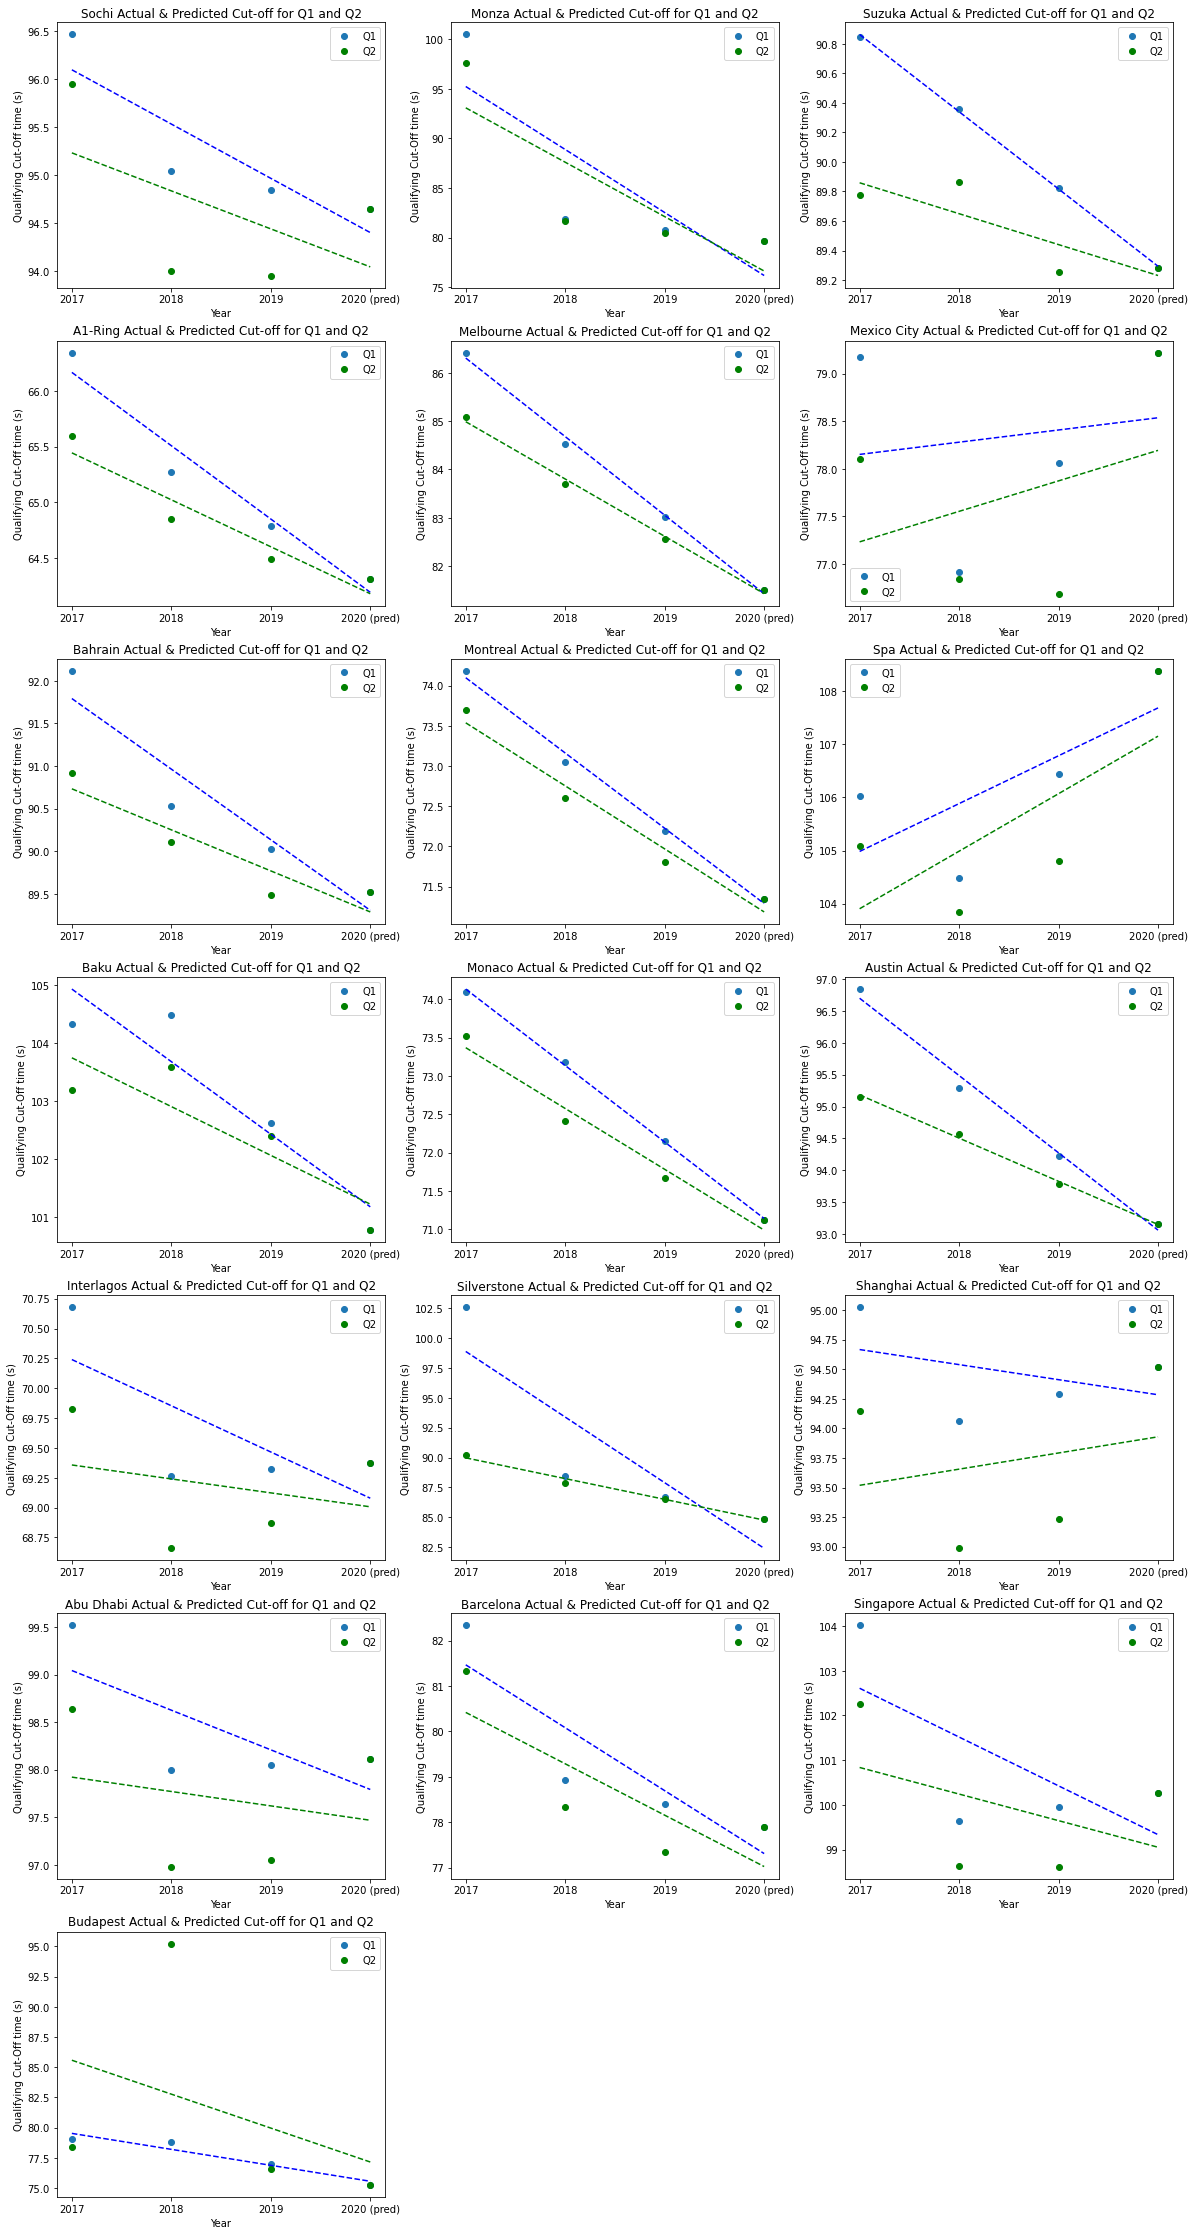

In [24]:
Q1 =  Q1_cutoff
Q2 =  Q2_cutoff

x = np.array([2017, 2018, 2019, 2020])

fig1 = plt.figure(figsize = (20, 40))

for i in range(1, 20):
    
    y1 = np.array([Q1.loc[i - 1][1], Q1.loc[i - 1][2], Q1.loc[i - 1][3], Q1.loc[i - 1][4]])
    y2 = np.array([Q2.loc[i - 1][1], Q2.loc[i - 1][2], Q2.loc[i - 1][3], Q1.loc[i - 1][4]])


    m1, c1 = np.polyfit(x, y1, 1)
    m2, c2 = np.polyfit(x, y2, 1)

    Y1 = m1 * x + c1
    Y2 = m2 * x + c2
    
    sub = fig1.add_subplot(7, 3, i)

    sub.plot(x, y1, 'o')
    sub.plot(x, y2, 'o', color = 'g')

    sub.plot(x, Y1, linestyle = '--', color = 'b')
    sub.plot(x, Y2, linestyle = '--', color = 'g')

    labels = ['2017', '2018', '2019', '2020 (pred)']
    
    sub.set_ylabel('Qualifying Cut-Off time (s)')
    sub.set_title(f'{Q1.loc[i - 1][0]} Actual & Predicted Cut-off for Q1 and Q2')
    sub.set_xlabel('Year')
    sub.set_xticks([2017, 2018, 2019, 2020])
    sub.set_xticklabels(labels)
    sub.legend(('Q1', 'Q2'))
    

**Comparison of predictions made via cut-off ratios and predictions made via cut-off directly**

In [27]:
Q1_ratio_pred = Q1_cutoff_ratios['Ratio Cut-off 2020 (pred)']
Q2_ratio_pred = Q2_cutoff_ratios['Ratio Cut-off 2020 (pred)']

Q1_diff = pd.DataFrame(Q1_cutoff['Cut-off 2020 (pred)'] - Q1_cutoff_ratios['Ratio Cut-off 2020 (pred)'], columns = ['Prediction difference'])
Q2_diff = pd.DataFrame(Q2_cutoff['Cut-off 2020 (pred)'] - Q2_cutoff_ratios['Ratio Cut-off 2020 (pred)'], columns = ['Prediction difference'])


Q1_comparison_predictions = Q1_cutoff.join(Q1_ratio_pred).join(Q1_diff)

Q2_comparison_predictions = Q2_cutoff.join(Q2_ratio_pred).join(Q2_diff)

In [28]:
Q1_comparison_predictions

,Circuit,Cut-off 2017,Cut-off 2018,Cut-off 2019,Cut-off 2020 (pred),Ratio Cut-off 2020 (pred),Prediction difference
0,Sochi,96.462,95.037,94.840,94.643,95.883,-1.240
1,Monza,100.489,81.888,80.784,79.680,93.548,-13.868
2,Suzuka,90.849,90.361,89.822,89.283,89.193,0.090
3,A1-Ring,66.345,65.271,64.789,64.307,64.854,-0.547
4,Melbourne,86.419,84.532,83.017,81.502,81.855,-0.353
5,Mexico City,79.176,76.911,78.065,79.219,82.671,-3.452
6,Bahrain,92.118,90.530,90.026,89.522,90.566,-1.044
7,Montreal,74.182,73.047,72.197,71.347,71.619,-0.272
8,Spa,106.028,104.489,106.435,108.381,111.970,-3.589
9,Baku,104.334,104.489,102.630,100.771,98.833,1.938


In [29]:
Q2_comparison_predictions

,Circuit,Cut-off 2017,Cut-off 2018,Cut-off 2019,Cut-off 2020 (pred),Ratio Cut-off 2020 (pred),Prediction difference
0,Sochi,95.948,93.995,93.950,93.905,95.735,-1.830
1,Monza,97.582,81.669,80.517,79.365,91.387,-12.022
2,Suzuka,89.778,89.864,89.254,88.644,87.915,0.729
3,A1-Ring,65.597,64.845,64.490,64.135,64.554,-0.419
4,Melbourne,85.081,83.692,82.562,81.432,81.654,-0.222
5,Mexico City,78.099,76.844,76.687,76.530,77.607,-1.077
6,Bahrain,90.923,90.105,89.488,88.871,89.041,-0.170
7,Montreal,73.690,72.606,71.800,70.994,71.297,-0.303
8,Spa,105.090,103.844,104.797,105.750,107.941,-2.191
9,Baku,103.186,103.585,102.398,101.211,99.633,1.578
